In [1]:
import mo_descriptor as md
import nn_frame as nn
import numpy as np
import subprocess
subprocess.run('export TF_INTRA_OP_PARALLELISM_THREADS=12', shell=True)

2022-12-21 02:22:21.032086: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-21 02:22:21.032230: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


CompletedProcess(args='export TF_INTRA_OP_PARALLELISM_THREADS=12', returncode=0)

In [2]:
'''
1. prepare rotated mo

'''
# lumo = md.MO_descriptor('data/lumo-s0.cube').make()
# homo = md.MO_descriptor('data/homo-s0.cube').make()
# # specify the scanning range
# x_rot = np.arange(0.0, 91, 5)
# y_rot = np.arange(0.0, 91, 5)
# z_rot = np.arange(0.0, 91, 5)

# homo_ = np.zeros(homo.shape)
# lumo_ = np.zeros(lumo.shape)
# homo_[:,0] = homo[:,0]
# lumo_[:,0] = lumo[:,0]


# homo_pair = md.MO_pair_descriptor(homo, homo).make()
# lumo_pair = md.MO_pair_descriptor(lumo, lumo).make()
# homo_pairs = np.zeros((len(x_rot)*len(y_rot)*len(z_rot),) + homo_pair.shape)
# lumo_pairs = np.zeros((len(x_rot)*len(y_rot)*len(z_rot),) + lumo_pair.shape)

# for kk,k in enumerate(z_rot):
#     k_ = k / 180 * np.pi
#     z_rot_tm = np.array([[np.cos(k_), -np.sin(k_), 0],[np.sin(k_), np.cos(k_), 0], [0,0,1]])
#     for ii,i in enumerate(x_rot):
#         i_ = i / 180 * np.pi
#         x_rot_tm = np.array([[1,0,0], [0, np.cos(i_), -np.sin(i_)],[0, np.sin(i_), np.cos(i_)]])
#         for jj,j in enumerate(y_rot):
#             j_ = j /180 * np.pi
#             idx = kk * len(x_rot) * len(y_rot) + ii * len(y_rot) + jj
#             y_rot_tm = np.array([[np.cos(j_), 0, np.sin(j_)],[0,1,0], [-np.sin(j_), 0, np.cos(j_)]])
#             homo_[:,1:] = np.einsum('ij,jk,kl,lm->im', homo[:,1:], x_rot_tm, y_rot_tm, z_rot_tm)
#             lumo_[:,1:] = np.einsum('ij,jk,kl,lm->im', lumo[:,1:], x_rot_tm, y_rot_tm, z_rot_tm)
#             homo_pair = md.MO_pair_descriptor(homo, homo_).make()
#             lumo_pair = md.MO_pair_descriptor(lumo, lumo_).make()
#             homo_pairs[idx] = homo_pair
#             lumo_pairs[idx] = lumo_pair
            
# np.save('homo_pair_rot.npy', homo_pairs)
# np.save('lumo_pair_rot.npy', lumo_pairs)

'\n1. prepare rotated mo\n\n'

In [2]:
homo_pairs = np.load('homo_pair_rot.npy')
lumo_pairs = np.load('lumo_pair_rot.npy')

In [3]:
'''
2. read coupling
'''
raw_data = np.loadtxt('../ML_Coupling/results_rot.csv', delimiter=',',comments='#')
c_homo = abs(raw_data[:,3])
c_lumo = abs(raw_data[:,4])

In [4]:
'''
3. preprocess data
'''
izero = []
for ii,i in enumerate(c_homo):
    if i<=0.0000:
        izero.append(ii)
        c_homo[ii] = 1e-9
print(len(izero))
homo_pairs = np.delete(homo_pairs, izero, 0)
c_homo = np.delete(c_homo, izero, 0)

izero = []
for ii,i in enumerate(c_lumo):
    if i<=0.0000:
        izero.append(ii)
        c_lumo[ii] = 1e-8
print(len(izero))


122
143


In [5]:
train_homo_pairs = homo_pairs[:]
train_lumo_pairs = lumo_pairs

train_c_homo = -np.log(c_homo)[:]
train_c_lumo = -np.log(c_lumo)

test_homo_pairs = homo_pairs
test_lumo_pairs = lumo_pairs

test_c_homo = c_homo
test_c_lumo = c_lumo

In [32]:
import copy
train_homo = copy.deepcopy(train_homo_pairs)
train_chomo = copy.deepcopy(train_c_homo)
print(len(train_chomo))
index = np.random.choice(len(train_c_homo), size=int(len(train_c_homo)*0.001), replace=False)
train_homo_ = np.delete(train_homo,index,0)
train_chomo_ = np.delete(train_chomo,index,0)
print(len(train_homo_))

6737
6731


In [33]:
iall = np.arange(len(train_c_homo))
idiff = np.setdiff1d(iall,index)
test_homo = np.delete(copy.deepcopy(train_homo_pairs),idiff,0)
test_chomo = np.delete(copy.deepcopy(train_chomo),idiff,0)

In [34]:
'''
4. load model
'''
setting = {'activation':'tanh', 'nn_shape':(256,256,256), 'batch_size':len(train_homo_), 'training_steps':200000,\
'learning_rate': 0.00008, 'decay_rate':0.95, 'decay_per_steps':1000, 'save_step':1000, 'drop_rate':0, 'save_path':'./nat_dimer_rot_%d'%len(train_homo_),\
'seed':None, 'debug_traj':False, 'pre_trained_path':'./nat_dimer_33884/'}
NN = nn.NN(setting_dict=setting)
NN.train(train_homo_,train_chomo_)

loss:  10.897006
training step:     0
loss:  0.375492483
training step:  1000
loss:  0.167069554
training step:  2000
loss:  0.0499563515
training step:  3000
loss:  0.0201567356
training step:  4000
loss:  0.00863359682
training step:  5000
loss:  0.00408071419
training step:  6000
loss:  0.00398171786
training step:  7000
loss:  0.00240018382
training step:  8000
loss:  0.00104411878
training step:  9000
loss:  0.0008552043
training step: 10000
loss:  0.00297786389
training step: 11000
loss:  0.00102450419
training step: 12000
loss:  0.000536196923
training step: 13000
loss:  0.000432663917
training step: 14000
loss:  0.000366340217
training step: 15000
loss:  0.000319870072
training step: 16000
loss:  0.0005457027
training step: 17000
loss:  0.00170464534
training step: 18000
loss:  0.000237742352
training step: 19000
loss:  0.000227767974
training step: 20000
loss:  0.000339968246
training step: 21000
loss:  0.000233388142
training step: 22000
loss:  0.000197930349
training step: 2

INFO:tensorflow:Assets written to: ./nat_dimer_rot_6731/model/assets


INFO:tensorflow:Assets written to: ./nat_dimer_rot_6731/model/assets


In [35]:
error1 = np.mean(np.multiply(abs(NN.model(train_homo_pairs, training=False).numpy().reshape((len(train_homo_pairs),))-train_c_homo), np.power(train_c_homo,-1))*100)
error2 = np.mean(np.multiply(abs(NN.model(train_homo_, training=False).numpy().reshape((len(train_homo_),))-train_chomo_), np.power(train_chomo_,-1))*100)
error3 = np.mean(np.multiply(abs(NN.model(test_homo, training=False).numpy().reshape((len(test_homo),))-test_chomo), np.power(test_chomo,-1))*100)
print('Error of full data set: %5.3f %% \nError of training set with %d samples: %5.3f %% \nError of testing set with %d samples: %5.3f %% '%(error1,len(train_homo_),error2,len(test_homo),error3))

Error of full data set: 0.355 % 
Error of training set with 6731 samples: 0.355 % 
Error of testing set with 6 samples: 0.214 % 


In [ ]:
'''
5. train the rotation data with pretrained model
'''
NN(train_homo_pairs, training=True)

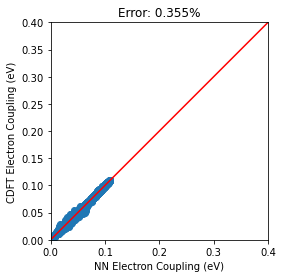

In [36]:
import matplotlib.pyplot as plt
# plotting
pred1 = NN.model(train_homo_pairs, training=False).numpy().reshape((len(train_homo_pairs),))
x = np.exp(-pred1) * 27.211
y1 = np.exp(-train_c_homo) * 27.211
y2 = train_c_lumo
x0 = [0,1.25]
y0 = [0,1.25]
fig, ax = plt.subplots()
ax.scatter(x,y1)
ax.plot(x0,y0, color='r')
ax.set_xlim(0,0.4)
ax.set_ylim(0,0.4)
ax.set_xlabel('NN Electron Coupling (eV)')
ax.set_ylabel('CDFT Electron Coupling (eV)')
ax.set_title('Error: %5.3f%%'%error1)
ax.set_aspect('equal')